In [23]:
import os
import sys
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt


from tqdm import tqdm
from itkwidgets import view
from collections import defaultdict
from openvino.inference_engine import IECore

In [ ]:
# TODO wget

### Define useful functions

In [24]:
def get_config():
    config = defaultdict(str)
    config.update(
            {"model": '../../../../facies_classification_benchmark/snap/DeconvNet_model.xml',
             "data_path": 'train_seismic.npy',
             "name_classes": ['upper_ns', 'middle_ns',
                            'lower_ns', 'rijnland_chalk',
                            'scruff', 'zechstein'],
             "cpu_extension": 'libuser_cpu_extension_for_max_unpool.so',
             "edge_one": (49,32,100),
             "edge_two": (149, 600, 244),
             "device":"CPU"})

    return config    

In [35]:
def normalize(data, mu=0, std=1):
    if not isinstance(data, np.ndarray):
        data = np.array(data)
    data = (data - data.flatten().mean())/data.flatten().std()
    return data * std + mu

def load_data(config):
    data_format = config["data_path"].split('.')[1]
    assert not (config["data_path"].split('.')[0] == '' or data_format == ''), \
        f'Invalid path to data file: {config["data_path"]}'
    if data_format == 'npy':
        data = np.load(config["data_path"])
    elif data_format == 'dat':
        data = np.fromfile(config["data_path"])
    elif data_format == 'segy':
        import segyio
        data = segyio.tools.cube(config["data_path"])
        data = np.moveaxis(data, -1, 0)
        data = np.ascontiguousarray(data, 'float32')
    else:
        assert False, f'Unsupported data format: {data_format}'

    data = normalize(data, mu=1e-8, std=0.2097654)
    print(f"[INFO] Dataset has been loaded, shape is {data.shape}")
    print(f"[INFO] Dataset mean is {data.flatten().mean():.5f}, std {data.flatten().std():.5f}")
    
    x_min =  min(config["edge_one"][0], config["edge_two"][0])
    x_max =  max(config["edge_one"][0], config["edge_two"][0])
    y_min =  min(config["edge_one"][1], config["edge_two"][1])
    y_max =  max(config["edge_one"][1], config["edge_two"][1])
    z_min =  min(config["edge_one"][2], config["edge_two"][2])
    z_max =  max(config["edge_one"][2], config["edge_two"][2])
    x_lim, y_lim, z_lim = data.shape
    assert x_min >=0 and y_min>=0 and z_min >= 0
    assert x_max < x_lim and y_max < y_lim and z_max < z_lim, "Invalid edges"
    sub_data = data[x_min: x_max , y_min: y_max, z_min: z_max]
    return sub_data

In [36]:
def reshape_model(net, shape):
    index_of_minimal_dim = np.argmin(shape)
    input_data_shape = list(shape)
    del input_data_shape[index_of_minimal_dim]

    input_net_info = net.input_info
    input_name = next(iter(input_net_info))
    input_net_shape = input_net_info[input_name].input_data.shape
    
    print(f"[INFO] Infer should be on {input_data_shape} resolution")
    if input_data_shape != input_net_shape[-2:]:
        net.reshape({input_name: [1, 1, *input_data_shape]})
        print(f"[INFO] Reshaping model to fit for slice shape: {input_data_shape}")
    else:
        print(f"[INFO] Use not reshaped model")

In [37]:
def infer_cube(exec_next, data):
    index_of_minimal_dim = np.argmin(data.shape)
    predicted_cube = np.empty(data.shape)
    size = data.shape[index_of_minimal_dim]
    for slice_index in tqdm(range(size)):
        if index_of_minimal_dim == 0:
            inp = data[slice_index, :, :]
            out = exec_net.infer(inputs={'input': inp})['output']
            out = np.argmax(out, axis=1).squeeze()
            predicted_cube[slice_index, :, :] = out
        if index_of_minimal_dim == 1:
            inp = data[:, slice_index, :]
            out = exec_net.infer(inputs={'input': inp})['output']
            out = np.argmax(out, axis=1).squeeze()
            predicted_cube[:, slice_index, :] = out
        if index_of_minimal_dim == 2:
            inp = data[:, :, slice_index]
            out = exec_net.infer(inputs={'input': inp})['output']
            out = np.argmax(out, axis=1).squeeze()
            predicted_cube[:, :, slice_index] = out
    return predicted_cube

In [38]:
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

def show_legend(N, cmap_name):
    base = plt.cm.get_cmap(cmap_name)
    color_list = base(np.linspace(0, 1, N))
    print(color_list)
    
def show_legend(labels, cmap):
    N = len(labels)
    fig = plt.figure(figsize=(12, 6))
    ax1 = fig.add_axes([0.05, 0.80, 0.9, 0.15])
    cb1 = mpl.colorbar.ColorbarBase(ax1, cmap=cmap,
                                    ticks=np.arange(0, N, 1)/N + 1/(2*N),
                                    orientation='horizontal')
    cb1.ax.set_xticklabels(labels, fontsize = 20)
    cb1.set_label('Legend', fontsize = 24)
    plt.show()

### Get config and load dataset

In [39]:
config = get_config()
data = load_data(config)

[INFO] Dataset has been loaded, shape is (401, 701, 255)
[INFO] Dataset mean is 0.00000, std 0.20977


### Load model

In [40]:
ie = IECore()
if config["cpu_extension"] and config["device"] == "CPU":
    ie.add_extension(config["cpu_extension"], "CPU")
net = ie.read_network(config["model"], os.path.splitext(config["model"])[0] + ".bin")

### Prepare model

In [41]:
reshape_model(net, data.shape)
exec_net = ie.load_network(network=net, device_name=config["device"])

[INFO] Infer should be on [568, 144] resolution
[INFO] Reshaping model to fit for slice shape: [568, 144]


### Run model

In [42]:
predicted_data = infer_cube(exec_net, data)

100%|██████████| 100/100 [00:11<00:00,  8.51it/s]


### Visualize original data

In [88]:
viewer_orig_data = view(data, shadow=False)
viewer_orig_data.cmap = np.array([[i/count, i/count, i/count] for i in range(100)])
viewer_orig_data

Viewer(cmap='Custom NumPy 1606930026.685257', geometries=[], gradient_opacity=0.22, point_sets=[], rendered_im…

### Visualize seismic interpretation

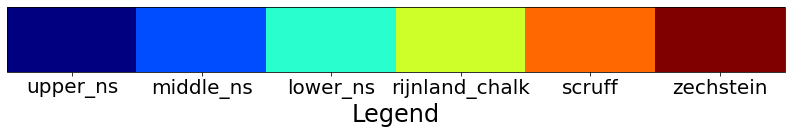

Viewer(camera=array([[ 2.6412067e+02, -3.6077603e+02,  7.9100334e+01],
       [ 7.1500000e+01,  9.4000000e+01,…

In [89]:
cmap = discrete_cmap(len(config["name_classes"]), 'jet')
show_legend(config["name_classes"], cmap)
viewer_interpret_data = view(predicted_data, shadow=False)
viewer_interpret_data.cmap = cmap
viewer_interpret_data.camera = viewer2.camera
viewer_interpret_data

In [90]:
viewer_interpret_data.camera = viewer_orig_data.camera